In [1]:
import copy
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

from src.utils import Osc, PCMFM
from src.NCO import NCO

## Research of delay-and-multiply scheme for carrier frequency estimation

In [2]:
# generate PCM/FM signal 

fs = 140e6
fc = 10e6
ampl = 1.
tau = 1e-2
R = 1e6
df = .35*R
bitsQnt = int(1000)
Navg = 100
filt=None

mod = PCMFM(fs, fc, ampl, tau, df, R, filt)
mod.automateSwitch(True, [.1])
mod.readAll();

0.0
828.4025583318669


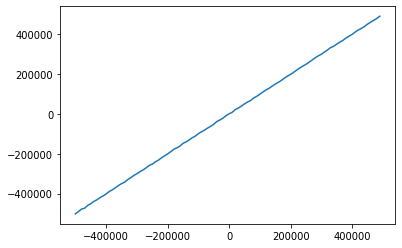

In [3]:
# decimate data to 4 samples per symbol approximately
inFilt = signal.firwin(250, 2.*R/(fs/2)) # anti-aliasing filter
delay = 1
perSymb = 4
DDCfactor = int( 2**np.floor(np.log2(fs / R / perSymb)) )

dfs = np.linspace(-R/2, R/2, 100, endpoint=False)
dfsEst = np.zeros_like(dfs)
for ii, df_ in enumerate(dfs):
    for jj in range(Navg):
        bits = np.random.randint(2, size=bitsQnt)
        mod.modulateOut(bits)
        FSKdata = mod.readAll()
        FSKdBb = signal.lfilter(inFilt, 1, FSKdata*np.exp(-1j*2*np.pi*(fc-df_)/fs*np.arange(len(FSKdata))))
        FSKdBbDs = signal.decimate(FSKdBb, DDCfactor, ftype='fir')
        dfEst = fs / (2*np.pi*delay*DDCfactor) * np.angle( 
            np.sum(FSKdBbDs[delay:delay+bitsQnt*perSymb] * FSKdBbDs[:bitsQnt*perSymb].conjugate()) )
        dfsEst[ii] += dfEst
        
dfsEst /= Navg
ind = np.argmin(np.abs(dfs))
print(dfs[ind])
print(dfsEst[ind])
plt.plot(dfs, dfsEst);

-141.49673633286716
12492.715731353845


C:\Anaconda3\envs\myHDLenv\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


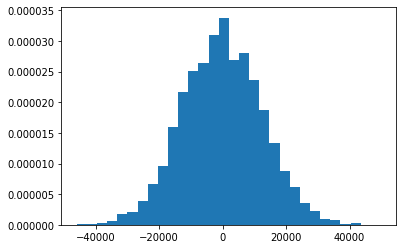

In [4]:
Nattempts = 10000
delay = 1
perSymb = 4
DDCfactor = int( 2**np.floor(np.log2(fs / R / perSymb)) )

dfsEst = np.zeros(Nattempts, dtype=float)
for ii in range(Nattempts):
    bits = np.random.randint(2, size=bitsQnt)
    mod.modulateOut(bits)
    FSKdata = mod.readAll()
    FSKdBb = signal.lfilter(inFilt, 1, FSKdata*np.exp(-1j*2*np.pi*fc/fs*np.arange(len(FSKdata))))
    FSKdBbDs = signal.decimate(FSKdBb, DDCfactor, ftype='fir')
    sum_ = np.sum(FSKdBbDs[delay:delay+bitsQnt*perSymb] * FSKdBbDs[:bitsQnt*perSymb].conjugate())
    dfEst = fs / (2*np.pi*delay*DDCfactor) * np.angle( sum_ )
    dfsEst[ii] = dfEst

print(np.mean(dfsEst))
print(np.std(dfsEst))
plt.hist(dfsEst, normed=True, bins=30);

### Feedforward carrier frequency estimator

* Frequency word of NCO:
$$ N_{NCO} = \frac{f_0}{f_s}\cdot{2^b} $$
where
    - $ f_s $ - sampling frequency
    - $ f_0 $ - NCO frequency, $ f_0 \in (\frac{-f_s}{2}, \frac{f_s}{2}) $
    - b - bitwidth of frequency word

* Frequency word step:
$$ \Delta N = \frac{{2^b}\cdot{\Delta f}}{f_s}  $$
where
    - $ \Delta f $ - frequency resolution

    For $ \Delta f = 100 Hz, b = 32, f_s = 140e6: $
$$ \Delta N = \frac{{2^{32}}\cdot{100}}{140e6} \approx 3067 $$

* Frequency word from feedforward frequency estimator:
$$ N_{NCO} = \frac{2^b\cdot\phi}{2\cdot{del}\cdot{dec}\cdot{2^{b_{\phi}-1}}} $$
where
    - $ \phi $ - integer angle of sum in delay-and-multiply scheme
    - $ del $ - delay in delay-and-multiply scheme
    - $ dec $ - decimation factor in preceding decimation filter
    - $ b_{\phi} $ - bitwidth of $ \phi $
    
* To estimate $ b_{\phi} $ you must calculate:
$$ b_{\phi} \geqslant 1 - log_2(\frac{2\cdot{\Delta N}\cdot{del}\cdot{dec}}{2^b}) $$
    For  $ del = 1, dec = 32, {\Delta N} = 3000, b = 32: $
$$ b_{\phi} \geqslant 1 - log_2(\frac{2\cdot{3000}\cdot{1}\cdot{32}}{2^{32}}) \approx 16 $$

* For preassigned $ b_{\phi} $:
$$ \Delta f = \frac{f_s}{2\cdot{del}\cdot{dec}\cdot{2^{b_{\phi}-1}}} $$

In [5]:
bw = 12
Is = np.arange(2**(bw-1))
Qs = np.arange(2**(bw-1))
Im, Qm = np.meshgrid(Is, Qs)
pnts = Im + 1j*Qm
angles = np.angle(pnts)
dAngs = np.diff(np.sort(np.unique(angles.flatten())))
dAngsMin = np.min(dAngs)

angBits = np.ceil(1 - np.log2(dAngsMin))
print(angBits)

24.0


So, for 12-bit data 24 bits for angle full resolution is required.

Finally, integer implementation will be look like:
![title](img/FEST_int.jpg)

In [6]:
class FEST(object):
    """ Feedforward carrier Frequency ESTimator for BFSK-type signals """
    
    def __init__(self, delay, frLen, fSymb, impl=('float', None)):
        """
            - delay - delay in delay-and-multiply scheme
            - frLen - number of samples in estimation frame
            - fSymb - symbol frequency (rate)
            - impl - implementation from [('float', None), ('int', kBw)], where
                ('float', None) - floating point implementation;
                ('int', kBw) - emulation of integer implementation, kBw - bitwidth of K 
        """
        self.delay = delay
        self.frLen = frLen
        self.fSymb = fSymb
        self.setImpl(impl)
        self._waitCnt = 0
        self.wait = False
        self.dataBuffer = np.array([], dtype=complex)
        self.delBuf = np.zeros(self.delay, dtype=complex)
        self.cordBw = 16 # temporary variable -- TODO: remove
        self.ncoBw = 32 # temporary variable -- TODO: remove
        self.dec = 32 # temporary variable -- TODO: remove
        
    def setImpl(self, impl):
        """ set implementation type of instance
            - impl - implementation from [('float', None), ('int', kBw)], where
                ('float', None) - floating point implementation;
                ('int', kBw) - emulation of integer implementation, kBw - bitwidth of K         
        """
        iType, args = impl
        self.iType = iType
        if self.iType == 'int':
            self.kBw = args
        if self.iType == 'float':
            self.K = self.fSymb / (2 * np.pi * self.delay)
        elif self.iType == 'int':
            self.K = np.round( 2**self.ncoBw / (self.delay * self.dec * 2**cordBw) )  # --TODO: modify
            
    def cordic(self, pnt):
        """ cordic fot calculation np.angle(pnt) in integer implementation
            - pnt - point cartesian coordinate system
            return angle, integer in (-2**(cordBw-1), 2**(cordBw-1))
        """
        pass
        
    def reset(self):
        """ Reset to initial state """
        self.delBuf.fill(0.)
        self.dataBuffer = np.array([], dtype=complex)
        self.wait = False
        self._waitCnt = 0
#         self.rtlRefs = np.array([], dtype=self.dtype) -- TODO: uncomment for rtl-model
#         self.rtlOuts = np.array([], dtype=self.dtype) -- TODO: uncomment for rtl-model

    def _setWait(self, n):
        """ Wait for loading additional n samples in dataBuffer
            n - number of additional required samples
        """
        self._waitCnt = n
        self.wait = True

    def loadIntoBuffer(self, d):
        """ Load samples from d into buffer """
        len_ = 1 if np.isscalar(d) else len(d)
        if len_ >= self._waitCnt:
            self._waitCnt = 0
            self.wait = False
        else:
            self._waitCnt -= len_
        self.dataBuffer = np.append(self.dataBuffer, d)
        
    def estimate(self):
        """ Estimate carrier frequency
            return carrier frequency estimation
        """
        if self.wait:
            return None
        else:
            if len(self.dataBuffer) < self.frLen:
                self._setWait(self.frLen - len(self.dataBuffer))
                return None
            else:
                self.wait = False
                data = self.dataBuffer[:self.frLen]
                dataDel = np.hstack((self.delBuf, self.dataBuffer[:self.frLen-self.delay]))
                self.delBuf = self.dataBuffer[-self.delay:]
                self.dataBuffer = np.delete(self.dataBuffer, np.arange(self.frLen))
                
                sum_ = np.sum(data * dataDel.conjugate())
                if self.iType == 'float':
                    dfEst = self.K * np.angle(sum_)
                elif self.iType == 'int':
                    dfEst = self.K * self.cordic(sum_) # -- TODO: replace internal function with class object
                return dfEst

Test floating point implementation:

-10.978666560189083
12488.679798628656


C:\Anaconda3\envs\myHDLenv\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


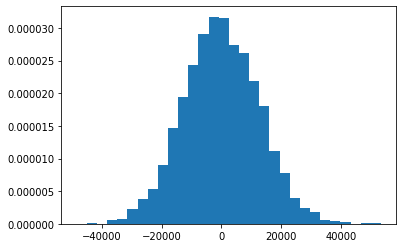

In [7]:
frLen = bitsQnt * perSymb
fSymb = fs / DDCfactor
impl = ('float', None)
fest = FEST(delay, frLen, fSymb, impl)

dfsEst = np.zeros(Nattempts, dtype=float)
for ii in range(Nattempts):
    bits = np.random.randint(2, size=bitsQnt)
    mod.modulateOut(bits)
    FSKdata = mod.readAll()
    FSKdBb = signal.lfilter(inFilt, 1, FSKdata*np.exp(-1j*2*np.pi*fc/fs*np.arange(len(FSKdata))))
    FSKdBbDs = signal.decimate(FSKdBb, DDCfactor, ftype='fir')
    fest.reset()
    fest.loadIntoBuffer(FSKdBbDs)
    dfEst = fest.estimate()
    dfsEst[ii] = dfEst

print(np.mean(dfsEst))
print(np.std(dfsEst))
plt.hist(dfsEst, normed=True, bins=30);

0.0
-348.3376141497184


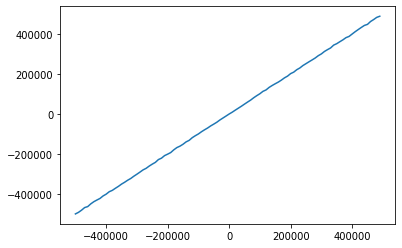

In [8]:
dfsEst = np.zeros_like(dfs)
for ii, df_ in enumerate(dfs):
    for jj in range(Navg):
        bits = np.random.randint(2, size=bitsQnt)
        mod.modulateOut(bits)
        FSKdata = mod.readAll()
        FSKdBb = signal.lfilter(inFilt, 1, FSKdata*np.exp(-1j*2*np.pi*(fc-df_)/fs*np.arange(len(FSKdata))))
        FSKdBbDs = signal.decimate(FSKdBb, DDCfactor, ftype='fir')
        fest.reset()
        fest.loadIntoBuffer(FSKdBbDs)
        dfEst = fest.estimate()
        dfsEst[ii] += dfEst
        
dfsEst /= Navg
ind = np.argmin(np.abs(dfs))
print(dfs[ind])
print(dfsEst[ind])
plt.plot(dfs, dfsEst);

In [108]:
def cordic(pnt, N, bw=16):
    angs = np.array([int(np.round(2**(bw-1)/np.pi * np.arctan(1/2**ii))) for ii in range(N)])
    x, y = int(pnt.real), int(pnt.imag)
    xprev = x
    z = 0
    # initial rotate by +/- np.pi/2
    if x >= 0:
        z = 0
    elif y >= 0:
        x = y
        y = -xprev
        xprev = x
        z = 2**(bw-2)
    else:
        x = -y
        y = xprev
        xprev = x
        z = - 2**(bw-2)
        
    for ii in range(N):
        if y >= 0:
            x = x + (y >> ii)
            y = y - (xprev >> ii)
            xprev = x
            z += angs[ii]
        elif y < 0:
            x = x - (y >> ii)
            y = y + (xprev >> ii)
            xprev = x
            z -= angs[ii]
    return z


bw = 16
np.random.seed(12458)
pnt = np.random.randint(1000) + 1j*np.random.randint(1000)
pnt = 10000 + 1j*55000

phi = cordic(pnt, 14, bw=16)
ref = int(np.round(2**(bw-1) / np.pi * np.angle(pnt)))
err = np.abs(phi - ref)
print(f" cordic: {phi}")
print(f" reference: {ref}")
print(f"error: {err}")

 cordic: 14507
 reference: 14508
error: 1


In [113]:
dBw = 12
bw = 16
compMin = 128
Is = np.arange(-2**(dBw-1), 2**(dBw-1))
Qs = np.arange(-2**(dBw-1), 2**(dBw-1))
Im, Qm = np.meshgrid(Is, Qs)
pnts = Im + 1j*Qm
anglesRef = (np.round(2**(bw-1) / np.pi * np.angle(pnts))).astype(int)
anglesTmp = np.zeros_like(anglesRef)
bitsMin = 8
bitsMax = 20
errsMax = np.zeros(bitsMax-bitsMin+1)
for ii in range(bitsMin, bitsMax+1):
    for jj in range(2**(dBw)):
        for kk in range(2**dBw):
            if (abs(jj-2**(dBw-1)) >=compMin) and (abs(kk-2**(dBw-1)) >=compMin):
                anglesTmp[jj, kk] = cordic((jj-2**(dBw-1)) + 1j*(kk-2**(dBw-1)), ii, bw=bw)
            else:
                anglesTmp[jj, kk] = anglesRef[jj, kk]
    errs = np.abs(anglesRef - anglesTmp)
    errsMax[ii-bitsMin] = np.max(errs)

print(errsMax)

KeyboardInterrupt: 